# Project: Markov chains and the supermarket

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px

plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use("ggplot")

## 1. Data exploration and preparation

In [2]:
monday = pd.read_csv("data/monday.csv", sep=";", parse_dates=["timestamp"])
tuesday = pd.read_csv("data/tuesday.csv", sep=";", parse_dates=["timestamp"])
wednesday = pd.read_csv("data/wednesday.csv", sep=";", parse_dates=["timestamp"])
thursday = pd.read_csv("data/thursday.csv", sep=";", parse_dates=["timestamp"])
friday = pd.read_csv("data/friday.csv", sep=";", parse_dates=["timestamp"])

In [3]:
frames = monday, tuesday, wednesday, thursday, friday
monday["day"] = "monday"
tuesday["day"] = "tuesday"
wednesday["day"] = "wednesday"
thursday["day"] = "thursday"
friday["day"] = "friday"

In [4]:
tuesday["customer_no"] += monday["customer_no"].max()
wednesday["customer_no"] += tuesday["customer_no"].max()
thursday["customer_no"] += wednesday["customer_no"].max()
friday["customer_no"] += thursday["customer_no"].max()

In [5]:
week = pd.concat(frames).reset_index()
week.head()

,index,timestamp,customer_no,location,day
0,0,2019-09-02 07:03:00,1,dairy,monday
1,1,2019-09-02 07:03:00,2,dairy,monday
2,2,2019-09-02 07:04:00,3,dairy,monday
3,3,2019-09-02 07:04:00,4,dairy,monday
4,4,2019-09-02 07:04:00,5,spices,monday


In [6]:
week["location"] = pd.Categorical(week["location"])
week['loc_num'] = week["location"].cat.codes

In [7]:
week.head(10)

,index,timestamp,customer_no,location,day,loc_num
0,0,2019-09-02 07:03:00,1,dairy,monday,1
1,1,2019-09-02 07:03:00,2,dairy,monday,1
2,2,2019-09-02 07:04:00,3,dairy,monday,1
3,3,2019-09-02 07:04:00,4,dairy,monday,1
4,4,2019-09-02 07:04:00,5,spices,monday,4
5,5,2019-09-02 07:04:00,6,spices,monday,4
6,6,2019-09-02 07:04:00,7,spices,monday,4
7,7,2019-09-02 07:04:00,8,fruit,monday,3
8,8,2019-09-02 07:05:00,1,checkout,monday,0
9,9,2019-09-02 07:05:00,5,checkout,monday,0


### Calculate the total number of customers in each section

In [8]:
week_count = week.groupby(['timestamp', "location", "day"]).agg({"customer_no":"count"}).reset_index()
week_count.rename(columns={"customer_no":"count"}, inplace=True)
week_count.head()

,timestamp,location,day,count
0,2019-09-02 07:03:00,checkout,friday,0
1,2019-09-02 07:03:00,checkout,monday,0
2,2019-09-02 07:03:00,checkout,thursday,0
3,2019-09-02 07:03:00,checkout,tuesday,0
4,2019-09-02 07:03:00,checkout,wednesday,0


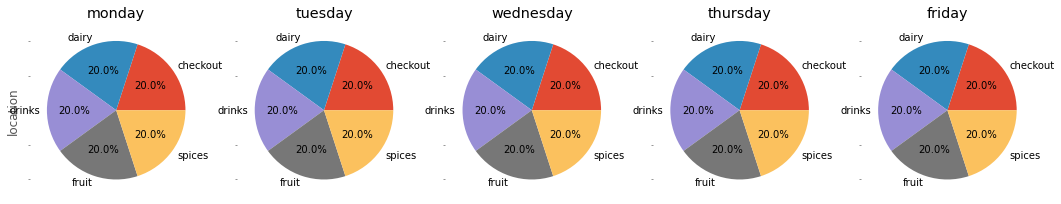

In [9]:
days = week["day"].unique()
f, axes = plt.subplots(1, 5, sharey=True, figsize=(18, 8))
for i, (ax, day) in enumerate(zip(axes, days)):
    week_count.loc[week_count["day"]==day]["location"].value_counts().plot(kind="pie", 
                                                                           autopct='%1.1f%%', 
                                                                           title=day,
                                                                           ax=ax)

### Display cumulated number of customers in each section

KeyboardInterrupt: 

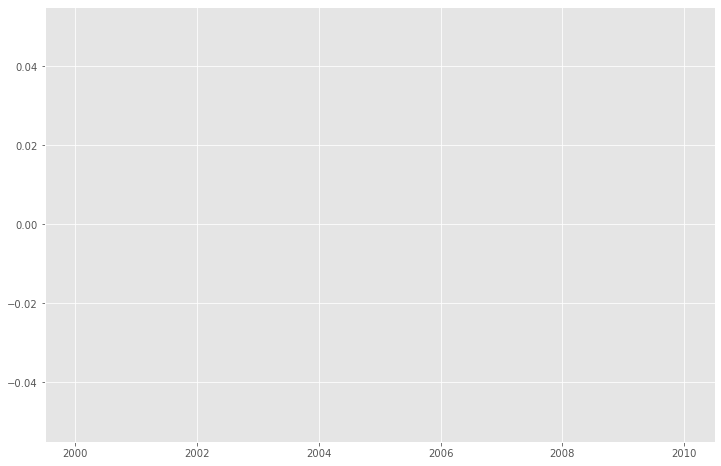

In [11]:
week_count["cumsum"] = week_count.groupby(["location"])["count"].cumsum()

fig, ax = plt.subplots(1, 1)
sns.lineplot(data=week_count, x="timestamp", y="cumsum", hue="location", ax=ax)
ax.set_ylabel("cumulated sum")
ax.set_xlabel("")
ax.set_title("Total number of customers visited each section");

### Display the number of customers at checkout over time

In [ ]:
checked_out = week_count[week_count["location"]=="checkout"]

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(12, 40))
for ax, day in zip(axes, days):
    checked_out.loc[checked_out["day"]==day].plot(x="timestamp", y="count", ax=ax)
    ax.set_ylim([0, 10])

### Calculate the time each customer spent in the market

In [ ]:
week = pd.concat(frames).reset_index().drop(columns=["index"])
week.head()

In [ ]:
week["start"] = week.groupby(["customer_no"])["timestamp"].transform(lambda x : min(x))
week["end"] = week.groupby(["customer_no"])["timestamp"].transform(lambda x : max(x))

In [ ]:
week["time spend in min"] = (week["end"] - week["start"]).dt.seconds/60

In [ ]:
week.head(10)

### How many customers didn't checked out

In [ ]:
mask = week["customer_no"]==1
"checkout" in week[mask]["location"].unique()
week["customer_no"].max()

In [ ]:
count = 0
indices = []
for i in range(1, week["customer_no"].max()+1):
    mask = week["customer_no"]==i
    bad_customer = "checkout" not in week[mask]["location"].unique()
    if bad_customer:
        indices.append(i)
        count += 1

In [ ]:
count

In [ ]:
week[week["time spend in min"]==0]

In [ ]:
print(indices)

In [250]:
week["customer_no"].max() - week["location"].value_counts()["checkout"]

28

In [297]:
mask = week.groupby(["customer_no"])["location"].transform(lambda x : "checkout" in "".join(map(str, x)))
week = week.loc[mask]

In [426]:
transitions = week.groupby(["customer_no"])["location"].transform(lambda x : " ".join(map(str, x)))

In [427]:
transitions.head(20)

0                                        dairy checkout
1                                        dairy checkout
2                                        dairy checkout
3                                        dairy checkout
4                                       spices checkout
5     spices dairy spices drinks spices dairy spices...
6                   spices drinks spices fruit checkout
7                                        fruit checkout
8                                        dairy checkout
9                                       spices checkout
10    spices dairy spices drinks spices dairy spices...
11                  spices drinks spices fruit checkout
12                                       dairy checkout
13                                       dairy checkout
14                                 dairy fruit checkout
15                                       fruit checkout
16                                      drinks checkout
17                               spices drinks c

### Calculate the total number of customers in the supermarket over time.

In [351]:
week.head(10)

,timestamp,customer_no,location,day,start,end,time spend in min
0,2019-09-02 07:03:00,1,dairy,monday,2019-09-02 07:03:00,2019-09-02 07:05:00,2.0
1,2019-09-02 07:03:00,2,dairy,monday,2019-09-02 07:03:00,2019-09-02 07:06:00,3.0
2,2019-09-02 07:04:00,3,dairy,monday,2019-09-02 07:04:00,2019-09-02 07:06:00,2.0
3,2019-09-02 07:04:00,4,dairy,monday,2019-09-02 07:04:00,2019-09-02 07:08:00,4.0
4,2019-09-02 07:04:00,5,spices,monday,2019-09-02 07:04:00,2019-09-02 07:05:00,1.0
5,2019-09-02 07:04:00,6,spices,monday,2019-09-02 07:04:00,2019-09-02 07:29:00,25.0
6,2019-09-02 07:04:00,7,spices,monday,2019-09-02 07:04:00,2019-09-02 07:13:00,9.0
7,2019-09-02 07:04:00,8,fruit,monday,2019-09-02 07:04:00,2019-09-02 07:07:00,3.0
8,2019-09-02 07:05:00,1,checkout,monday,2019-09-02 07:03:00,2019-09-02 07:05:00,2.0
9,2019-09-02 07:05:00,5,checkout,monday,2019-09-02 07:04:00,2019-09-02 07:05:00,1.0


In [325]:
week["timestamp"].head(10)

0   2019-09-02 07:03:00
1   2019-09-02 07:03:00
2   2019-09-02 07:04:00
3   2019-09-02 07:04:00
4   2019-09-02 07:04:00
5   2019-09-02 07:04:00
6   2019-09-02 07:04:00
7   2019-09-02 07:04:00
8   2019-09-02 07:05:00
9   2019-09-02 07:05:00
Name: timestamp, dtype: datetime64[ns]

In [323]:
week.loc[0, "end"] - week.loc[0, "start"] 

Timedelta('0 days 00:02:00')

In [345]:
time = np.asarray(week["timestamp"])

In [354]:
week[week["customer_no"]==1]

,timestamp,customer_no,location,day,start,end,time spend in min
0,2019-09-02 07:03:00,1,dairy,monday,2019-09-02 07:03:00,2019-09-02 07:05:00,2.0
8,2019-09-02 07:05:00,1,checkout,monday,2019-09-02 07:03:00,2019-09-02 07:05:00,2.0


In [417]:
mask = np.logical_and(week["timestamp"] < pd.to_datetime("2019-09-02 07:05:00"), time > pd.to_datetime("2019-09-02 07:03:00"))
start_end = week.groupby(["customer_no"])[["start", "end"]].min()

In [422]:
for i in range(1, week["customer_no"].max() + 1):
    mask = np.logical_and(time < start_end.loc[i, "end"], time > start_end.loc[i, "start"])
    week[mask]["timestamp"].unique()

KeyError: 1430

In [416]:
start_end = week.groupby(["customer_no"])[["start", "end"]].min()

,start,end
customer_no,,
1,2019-09-02 07:03:00,2019-09-02 07:05:00
2,2019-09-02 07:03:00,2019-09-02 07:06:00
3,2019-09-02 07:04:00,2019-09-02 07:06:00
4,2019-09-02 07:04:00,2019-09-02 07:08:00
5,2019-09-02 07:04:00,2019-09-02 07:05:00
...,...,...
7436,2019-09-06 21:46:00,2019-09-06 21:48:00
7437,2019-09-06 21:46:00,2019-09-06 21:47:00
7439,2019-09-06 21:47:00,2019-09-06 21:48:00


In [402]:
week.tail()

,timestamp,customer_no,location,day,start,end,time spend in min
24862,2019-09-06 21:48:00,7439,checkout,friday,2019-09-06 21:47:00,2019-09-06 21:48:00,1.0
24865,2019-09-06 21:48:00,7442,dairy,friday,2019-09-06 21:48:00,2019-09-06 21:50:00,2.0
24866,2019-09-06 21:48:00,7443,dairy,friday,2019-09-06 21:48:00,2019-09-06 21:50:00,2.0
24873,2019-09-06 21:50:00,7442,checkout,friday,2019-09-06 21:48:00,2019-09-06 21:50:00,2.0
24874,2019-09-06 21:50:00,7443,checkout,friday,2019-09-06 21:48:00,2019-09-06 21:50:00,2.0
